In [1]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.templates.default = "plotly_white"


In [2]:
# Cameras
IMAGE_SIZE  = 240
CAMERAS = ['front', 'back']

# Scene
# [x_min, y_min, z_min, x_max, y_max, z_max] - the metric volume to be voxelized
SCENE_BOUNDS    = [-1.5, -1.5, -1.5, 1.50, 1.5, 1.5]

# Agents
AGENTS = ['Franka0', 'Franka1']

In [3]:
# load data
DATASET_PATH = '../outputs/dualarms_2cam/dualarms_2cam_with_fk.pkl'
with open(DATASET_PATH, 'rb') as f:
    _obs = pickle.load(f)

## Figure

camera: front
keys: dict_keys(['rgb', 'depth', 'position', 'resolution', 'extrinsics', 'intrinsics', 'pointcloud'])
rgb (240, 240, 3)
depth (240, 240)
pcd (240, 240, 3)
resolution [240, 240]


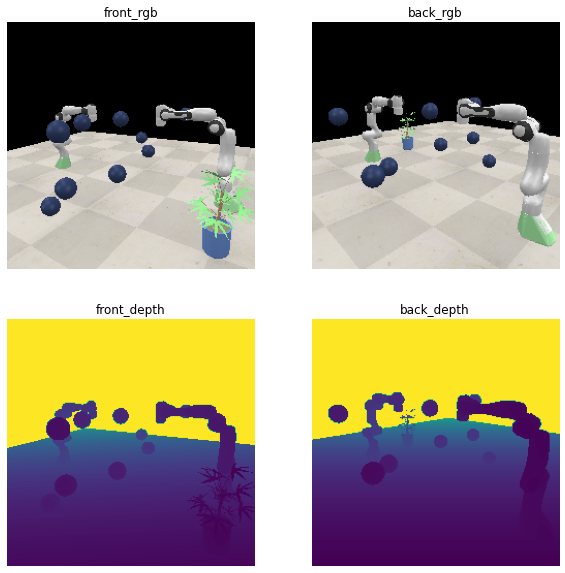

In [4]:
# show keys and shape
idx = -1
CAMERA = CAMERAS[0]
print('camera:', CAMERA)
print('keys:',_obs[idx][CAMERA].keys())
print('rgb',_obs[idx][CAMERA]['rgb'].shape)
print('depth',_obs[idx][CAMERA]['depth'].shape)
print('pcd',_obs[idx][CAMERA]['pointcloud'].shape)
print('resolution',_obs[idx][CAMERA]['resolution'])


# plot rgb and depth camera
fig = plt.figure(figsize=(10, 10))
rows, cols = 2, len(CAMERAS)
plot_idx = 1
for camera in CAMERAS:
    fig.add_subplot(rows, cols, plot_idx)
    plt.imshow(_obs[idx][camera]['rgb'])
    plt.axis('off')
    plt.title("%s_rgb" % (camera))

    fig.add_subplot(rows, cols, plot_idx+len(CAMERAS))
    plt.imshow(_obs[idx][camera]['depth'])
    plt.axis('off')
    plt.title("%s_depth" % (camera))
    plot_idx += 1
plt.show()

In [5]:
def constrain_scene_bounds(pcd):
    global SCENE_BOUNDS
    pcd = pcd[:, ( (pcd[0,:] > SCENE_BOUNDS[0]) & (pcd[0,:] < SCENE_BOUNDS[3])  )] # x axis constrainsts
    pcd = pcd[:, ( (pcd[1,:] > SCENE_BOUNDS[1]) & (pcd[1,:] < SCENE_BOUNDS[4])  )] # y axis constrainsts
    pcd = pcd[:, ( (pcd[2,:] > SCENE_BOUNDS[2]) & (pcd[2,:] < SCENE_BOUNDS[5])  )] # z axis constrainsts
    return pcd


def constrain_scene_bounds2(pcd, rgb):
    global SCENE_BOUNDS

    # x axis constraints
    mask = ( (pcd[0,:] > SCENE_BOUNDS[0]) & (pcd[0,:] < SCENE_BOUNDS[3])  )
    pcd = pcd[:, mask] 
    rgb = rgb[:, mask]

    # y axis constraints
    mask = ( (pcd[1,:] > SCENE_BOUNDS[1]) & (pcd[1,:] < SCENE_BOUNDS[4])  )
    pcd = pcd[:, mask] 
    rgb = rgb[:, mask]
    
    # z axis constraints
    mask = ( (pcd[2,:] > SCENE_BOUNDS[2]) & (pcd[2,:] < SCENE_BOUNDS[5])  )
    pcd = pcd[:, mask] 
    rgb = rgb[:, mask]

    return pcd, rgb

In [6]:
def visualize_scene_from_pcd() -> go.Figure:
    
    fig = make_subplots(
        rows=1, cols=2,
        specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}],],
        horizontal_spacing = 0.00,
        vertical_spacing = 0.00,
        subplot_titles=('front_pointcloud', 'back_pointcloud')
    )

    idx = -1
    for i, camera in enumerate(CAMERAS):
        # print(camera)

        # get pointcloud
        pcd = _obs[idx][camera]['pointcloud'].transpose(2,0,1).reshape(3,-1)

        # get rgb
        rgb = _obs[idx][camera]['rgb'].transpose(2,0,1).reshape(3,-1)
        rgb = ((rgb - 0.0) * 255.0) / 1.0 + 0.0

        # constrain scene
        pcd, rgb = constrain_scene_bounds2(pcd, rgb)
        color = [f'rgb({rgb[0,i]},{rgb[1,i]},{rgb[2,i]})' for i in range(rgb.shape[1])]

        fig.add_trace(
            go.Scatter3d(
                x = pcd[0,:],
                y = pcd[1,:],
                z = pcd[2,:],
                mode='markers',
                marker=dict(
                    size=2,
                    color=color,
                    # color=pcd[0,:],
                    # colorscale='Turbo',
                ),
                name=camera
            ),
            row=1, 
            col=i+1,
        )

    fig.update_layout(
        autosize=False,
        width=1000,
        height=500,
    )

    fig.write_html('../outputs/dualarms_2cam/dualarms_2cam_with_fk_pc.html')

    return fig



# visualize_scene_from_pcd().show()

## Meshes and Bounding Boxes

In [7]:
ROOT = '/home/dev/ws_percept/src'

In [8]:
from scipy.spatial.transform import Rotation as R
def get_tf(rotation:np.array, translation:np.array) -> np.array:

  r = R.from_rotvec(rotation)
  r = r.as_matrix()

  tf = np.eye(4)
  tf[:3,:3] = r
  tf[:3,3] = translation
  
  return tf

In [9]:
import os
import numpy as np
import cupoch as cph

path = os.path.join(ROOT, 'outputs/testdata/franka_panda_cupoch_2/panda.urdf')
kin = cph.kinematics.KinematicChain(path)

def compute_fk(obs):

    # get joints
    joint_map = dict()
    for i, val in enumerate(obs['joint_pos']):
        # joint_map[f'panda_joint{i}'] = val
        joint_map[f'panda_joint{i+1}'] = val


    # pose, angle, and transformation matrix
    pos = obs['global_pos']
    rot = obs['global_ang']
    # pos += np.array([0.0, -0.04, -0.05])
    pos += np.array([0.0, 0.0, -0.05])

    tf_matrix = get_tf(rot, pos)
    # tf_matrix = np.eye(4)

    # prints
    print(f"pos: {pos}\nrot: {rot}")
    print(f"tf_matrix:\n{tf_matrix}\n")

    # fk
    poses = kin.forward_kinematics(joint_map, tf_matrix)
    
    # store geoms
    geoms = kin.get_transformed_visual_geometry_map(poses)
    
    return poses, list(geoms.values())


obs = _obs[1]

# FK for agent 0
agent1 = AGENTS[0]
poses1, geoms1 = compute_fk(obs[agent1])

# FK for agent 1
agent2 = AGENTS[1]
poses2, geoms2 = compute_fk(obs[agent2])

# cph.visualization.draw_geometries(geoms1+geoms2)

pos: [-0.60000002 -1.          0.01999997]
rot: [-0.          0.          1.57079637]
tf_matrix:
[[-4.37113901e-08 -1.00000000e+00  0.00000000e+00 -6.00000024e-01]
 [ 1.00000000e+00 -4.37113901e-08  0.00000000e+00 -1.00000000e+00]
 [-0.00000000e+00  0.00000000e+00  1.00000000e+00  1.99999705e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

pos: [-0.60000002  1.          0.01999997]
rot: [ 0.          0.         -1.57079637]
tf_matrix:
[[-4.37113901e-08  1.00000000e+00  0.00000000e+00 -6.00000024e-01]
 [-1.00000000e+00 -4.37113901e-08 -0.00000000e+00  1.00000000e+00]
 [-0.00000000e+00  0.00000000e+00  1.00000000e+00  1.99999705e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]



In [10]:

def create_trace_from_mesh(mesh) -> go.Scatter3d:
    try:
        mesh = np.asarray(np.sum(np.array(mesh)).vertices.cpu()).transpose(1,0).reshape(3,-1)
        return go.Scatter3d(
                x=mesh[0,:], 
                y=mesh[1,:], 
                z=mesh[2,:],
                mode='markers',
                marker=dict(
                    size=1,
                    opacity=1.0,
                    color=mesh[2,:],
                    colorscale='Turbo',
                ),
            )
    except:
        return None

def visualize_fk_mesh(geoms1, geoms2) -> go.Figure:
    fig = go.Figure()
         

    for mesh in geoms1:
        fig.add_trace(create_trace_from_mesh(mesh))

    for mesh in geoms2:
        fig.add_trace(create_trace_from_mesh(mesh))

    fig.update_layout(
        autosize=False,
        width=1000,
        height=500,
        scene = dict(
            xaxis = dict(range=[-1.7,0.7],),
            yaxis = dict(range=[-1.2,1.2],),
            zaxis = dict(range=[-0.7,1.7],),),
    )


    fig.write_html('../outputs/dualarms_2cam/fk_meshes.html')
    return fig

# visualize_fk_mesh(geoms1, geoms2).show()

In [11]:
idx = -1


def overlay_meshes_on_pointcloud_scene(geoms1, geoms2) -> go.Figure:

    fig = make_subplots(
        rows=1, cols=2,
        specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}],],
        horizontal_spacing = 0.00,
        vertical_spacing = 0.00,
        subplot_titles=('front_pointcloud', 'back_pointcloud')
    )

    for i, camera in enumerate(CAMERAS):
        # print(camera)

        # get pointcloud
        pcd = _obs[idx][camera]['pointcloud'].transpose(2,0,1).reshape(3,-1)

        # get rgb
        rgb = _obs[idx][camera]['rgb'].transpose(2,0,1).reshape(3,-1)
        rgb = ((rgb - 0.0) * 255.0) / 1.0 + 0.0

        # constrain scene
        pcd, rgb = constrain_scene_bounds2(pcd, rgb)
        color = [f'rgb({rgb[0,i]},{rgb[1,i]},{rgb[2,i]})' for i in range(rgb.shape[1])]

        fig.add_trace(
            go.Scatter3d(
                x = pcd[0,:],
                y = pcd[1,:],
                z = pcd[2,:],
                mode='markers',
                marker=dict(
                    size=2,
                    color=color,
                    # color=pcd[0,:],
                    # colorscale='Turbo',
                ),
                name=camera
            ),
            row=1, 
            col=i+1,
        )

        # arm1 in scene
        for mesh in geoms1:
            trace = create_trace_from_mesh(mesh)
            fig.add_trace(
                trace,
                row=1, 
                col=i+1,
            )

        # arms2 in scene
        for mesh in geoms2:
            trace = create_trace_from_mesh(mesh)
            fig.add_trace(
                trace,
                row=1, 
                col=i+1,
            )

    fig.update_layout(
        autosize=False,
        width=1000,
        height=500,
    )
    fig.write_html('../outputs/dualarms_2cam/dualarms_2cam_with_fk_pc_and_mesh.html')
    return fig

# overlay_meshes_on_pointcloud_scene(geoms1, geoms2).show()

In [12]:
import open3d as o3d
from open3d.geometry import OrientedBoundingBox as OBB

def get_bb_array_from_mesh(mesh)->np.array:
    try:
        mesh_points = np.array(mesh.vertices.cpu())
        bb = OBB.create_from_points(
            o3d.utility.Vector3dVector(mesh_points)
        ).get_box_points()
        return np.asarray(bb)#.transpose(1,0)
    except:
        return None

def get_bb_trace_from_mesh(mesh, color='blue'):
    bb = get_bb_array_from_mesh(mesh)
    if bb is not None:
        bb = bb.transpose(1,0)
        return go.Mesh3d(
            x=bb[0,:],
            y=bb[1,:], 
            z=bb[2,:],
            alphahull=0,
            opacity=0.1,
            color=color
        )
    else:
        return None

def show_oriented_bounding_boxes(geoms1, geoms2) -> go.Figure:

    fig = go.Figure()

    for mesh in geoms1:

        try:
            trace = get_bb_trace_from_mesh(mesh, color='blue')
            if trace is not None:
                fig.add_trace(trace)

            trace = create_trace_from_mesh(mesh)
            fig.add_trace(trace)
        except Exception as e:
            print(e)
            # print(mesh)

    for mesh in geoms2:
        mesh_points = np.array(mesh.vertices.cpu())
        try:
            trace = get_bb_trace_from_mesh(mesh, color='red')
            if trace is not None:
                fig.add_trace(trace)

            trace = create_trace_from_mesh(mesh)
            
            fig.add_trace(trace)
        except Exception as e:
            # print(e)
            print(mesh)


    fig.update_layout(
        autosize=False,
        width=1000,
        height=500,
        scene = dict(
            xaxis = dict(range=[-1.7,0.7],),
            yaxis = dict(range=[-1.2,1.2],),
            zaxis = dict(range=[-0.7,1.7],),),
    )

    fig.write_html('../outputs/dualarms_2cam/fk_meshes_with_bb.html')

    return fig


# show_oriented_bounding_boxes(geoms1, geoms2).show()   

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Do RBS using BB

In [13]:
# https://computergraphics.stackexchange.com/questions/13487/fast-algorithm-to-check-if-a-point-is-inside-outside-mesh

In [14]:
# select pcd
idx=-1
camera=CAMERAS[0]
pcd = _obs[idx][camera]['pointcloud']
pcd = pcd.reshape(-2,3)
pcd.shape

(57600, 3)

In [15]:
# select pcd
idx=-1
camera=CAMERAS[0]
pcd = _obs[idx][camera]['pointcloud']
pcd = pcd.reshape(-2,3)
rgb = _obs[idx][camera]['rgb'].reshape(-2,3)


def get_bb_from_mesh(mesh) -> OBB:
    try:
        mesh_points = np.array(mesh.vertices.cpu())
        bb = OBB.create_from_points(
            o3d.utility.Vector3dVector(mesh_points)
        )
        return bb
    except:
        # print(mesh_points)
        return None


def do_rbs(
    pcd:np.array, 
    geoms:list,
    rgb=None,
) -> np.array:
    masks = list()
    n = pcd.shape[0] # pcd.shape = (240x240, 3)

    for mesh in geoms:
        bb = get_bb_from_mesh(mesh)
        if bb is not None:
            mask = np.zeros(n, dtype=bool)
            indices_points_within_bb = np.array(
                bb.get_point_indices_within_bounding_box(
                    o3d.utility.Vector3dVector(pcd)
                )
            )
            mask[indices_points_within_bb] = True
            masks.append(mask)
        else:
            pass

    mask = np.column_stack(tuple(masks)).any(axis=1)
    mask = ~mask # inverting mask to get pcd which were not within any BBs

    if rgb is not None:
        return (pcd[mask], rgb[mask]) 
    
    else:
        return pcd[mask] 


# pcd = do_rbs(pcd, geoms1)

# in prod, we do not need rgb
pcd, rgb = do_rbs(pcd, geoms1, rgb=rgb)
pcd, rgb = do_rbs(pcd, geoms2, rgb=rgb) 

pcd, rgb = constrain_scene_bounds2(pcd.transpose(1,0), rgb.transpose(1,0)) # in prod, this will need to be before RBS for performance 
rgb = ((rgb - 0.0) * 255.0) / 1.0 + 0.0

In [16]:

def visualize_scene(
    pcd:np.array, 
    rgb:np.array
) -> go.Figure:
    fig = go.Figure()
    color = [f'rgb({rgb[0,i]},{rgb[1,i]},{rgb[2,i]})' for i in range(rgb.shape[1])]


    fig.add_trace(
        go.Scatter3d(
            x = pcd[0,:],
            y = pcd[1,:],
            z = pcd[2,:],
            mode='markers',
            marker=dict(
                size=2,
                color=color,
                # color=pcd[0,:],
                # colorscale='Turbo',
            ),
            name=camera
        ),
        # row=1, 
        # col=i+1,
    )

    for mesh in geoms1:
        trace = get_bb_trace_from_mesh(mesh, color='blue')
        if trace:
            fig.add_trace(trace)

    for mesh in geoms2:
        trace = get_bb_trace_from_mesh(mesh, color='red')
        if trace:
            fig.add_trace(trace)

    fig.update_layout(
        autosize=False,
        width=1000,
        height=500,
    )

    fig.write_html('../outputs/dualarms_2cam/rbs_with_bb.html')

    return fig


visualize_scene(pcd, rgb).show()


## Make Class